In [1]:
!pip install transformers torch

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Load dataset
df = pd.read_csv('youtube_comments_topics.csv')
print(f"Jumlah data: {len(df)} komentar")
print(f"Kolom: {list(df.columns)}")
print()

# Load singkatan library
singkatan_df = pd.read_csv('singkatan-lib.csv', header=None, names=['singkatan', 'baku'])
singkatan_dict = dict(zip(singkatan_df['singkatan'], singkatan_df['baku']))
print(f"Jumlah singkatan: {len(singkatan_dict)}")
print()

# Informasi topik
print("Informasi Topik dalam Dataset:")
topic_counts = df['dominant_topic'].value_counts().sort_index()
for topic, count in topic_counts.items():
    print(f"  Topik {topic}: {count} komentar ({count/len(df)*100:.2f}%)")
print()

Jumlah data: 9903 komentar
Kolom: ['publishedAt', 'authorDisplayName', 'textDisplay', 'likeCount', 'text_clean', 'dominant_topic', 'topic_probability']

Jumlah singkatan: 175

Informasi Topik dalam Dataset:
  Topik 1: 1633 komentar (16.49%)
  Topik 2: 2186 komentar (22.07%)
  Topik 3: 750 komentar (7.57%)
  Topik 4: 2706 komentar (27.33%)
  Topik 5: 2628 komentar (26.54%)



In [4]:
# Fungsi Membersihkan Teks
def clean_text_bert(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Hapus HTML & URL
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Hapus Mention & Hashtag sign
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Fungsi Normalisasi Singkatan
def normalize_singkatan(text, singkatan_dict):
    words = text.split()
    normalized = []
    for word in words:
        if word in singkatan_dict:
            normalized.append(singkatan_dict[word])
        else:
            normalized.append(word)
    return ' '.join(normalized)

In [5]:
# Cleaning Dasar
# Pastikan nama kolom 'text_clean' sesuai dengan CSV kamu
df['text_processed'] = df['textDisplay'].apply(clean_text_bert)

# Normalisasi Singkatan
df['text_processed'] = df['text_processed'].apply(lambda x: normalize_singkatan(x, singkatan_dict))

# Cek hasil cleaning
print("\nCek 5 data teratas hasil cleaning:")
print(df['text_processed'].head())


Cek 5 data teratas hasil cleaning:
0     makasih berkat kamu saya jadi bodoh amat kemarin
1    anak abah cs dan banteng pasti pada emosi 😅 ka...
2    tau tidak china pki....tai china bangsat....br...
3    harusnya elu susul tuh si atheis lee kuan yew....
4    terlalu banyak otak kosong dan terlalu banyak ...
Name: text_processed, dtype: object


In [6]:
device = 0 if torch.cuda.is_available() else -1
sentiment_analysis = pipeline("sentiment-analysis",
                              model="w11wo/indonesian-roberta-base-sentiment-classifier",
                              device=device)

def get_sentiment_indobert(text):
    try:
        # Batasi 512 karakter agar tidak error
        text = text[:512]
        result = sentiment_analysis(text)[0]
        label = result['label']

        if label == 'positive': return 'Positif'
        elif label == 'negative': return 'Negatif'
        else: return 'Netral'
    except:
        return 'Netral'

print("Menganalisis sentimen...")
df['sentiment_label'] = df['text_processed'].apply(get_sentiment_indobert)

# Buat kolom angka untuk keperluan grafik
mapping = {'Positif': 1, 'Negatif': -1, 'Netral': 0}
df['sentiment_polarity'] = df['sentiment_label'].map(mapping)

print("\nDistribusi Sentimen:")
print(df['sentiment_label'].value_counts())
print("\nContoh Hasil Akhir:")
print(df[['text_processed', 'sentiment_label']].head())

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Menganalisis sentimen...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Distribusi Sentimen:
sentiment_label
Negatif    6395
Positif    2372
Netral     1136
Name: count, dtype: int64

Contoh Hasil Akhir:
                                      text_processed sentiment_label
0   makasih berkat kamu saya jadi bodoh amat kemarin         Negatif
1  anak abah cs dan banteng pasti pada emosi 😅 ka...         Negatif
2  tau tidak china pki....tai china bangsat....br...         Negatif
3  harusnya elu susul tuh si atheis lee kuan yew....         Negatif
4  terlalu banyak otak kosong dan terlalu banyak ...         Negatif


In [7]:
def get_top_words(texts, n=10):
    """Mendapatkan kata-kata yang paling sering muncul"""
    all_words = []
    for text in texts:
        words = str(text).split()
        all_words.extend([w for w in words if len(w) > 3])

    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Ekstraksi kata kunci untuk setiap kombinasi topik-sentimen
print("Kata Kunci Top 5 untuk Setiap Topik dan Sentimen:")
print()

for topic in sorted(df['dominant_topic'].unique()):
    print(f"TOPIK {topic}:")
    topic_data = df[df['dominant_topic'] == topic]

    for sentiment in ['Positif', 'Netral', 'Negatif']:
        sentiment_data = topic_data[topic_data['sentiment_label'] == sentiment]
        if len(sentiment_data) > 0:
            top_words = get_top_words(sentiment_data['text_processed'], n=5)
            print(f"  {sentiment} ({len(sentiment_data)} komentar):")
            for word, freq in top_words:
                print(f"    - {word}: {freq}")
    print()

Kata Kunci Top 5 untuk Setiap Topik dan Sentimen:

TOPIK 1:
  Positif (210 komentar):
    - yang: 126
    - bang: 60
    - saya: 45
    - tidak: 33
    - kita: 32
  Netral (169 komentar):
    - yang: 34
    - bang: 24
    - perampasan: 19
    - aset: 18
    - dari: 16
  Negatif (1254 komentar):
    - yang: 936
    - tidak: 420
    - saya: 279
    - mereka: 222
    - dari: 209

TOPIK 2:
  Positif (277 komentar):
    - yang: 245
    - kita: 113
    - tidak: 96
    - bisa: 82
    - dengan: 78
  Netral (206 komentar):
    - yang: 45
    - rakyat: 37
    - bang: 25
    - presiden: 24
    - darurat: 23
  Negatif (1703 komentar):
    - yang: 2165
    - tidak: 896
    - rakyat: 616
    - darurat: 469
    - sudah: 467

TOPIK 3:
  Positif (141 komentar):
    - yang: 68
    - bang: 35
    - tidak: 27
    - saya: 25
    - kita: 24
  Netral (87 komentar):
    - close: 16
    - door: 14
    - logo: 13
    - yang: 11
    - tidak: 9
  Negatif (522 komentar):
    - yang: 275
    - tidak: 169
    - suda

Visualisasi berhasil disimpan: visualisasi_sentimen_aspek.png



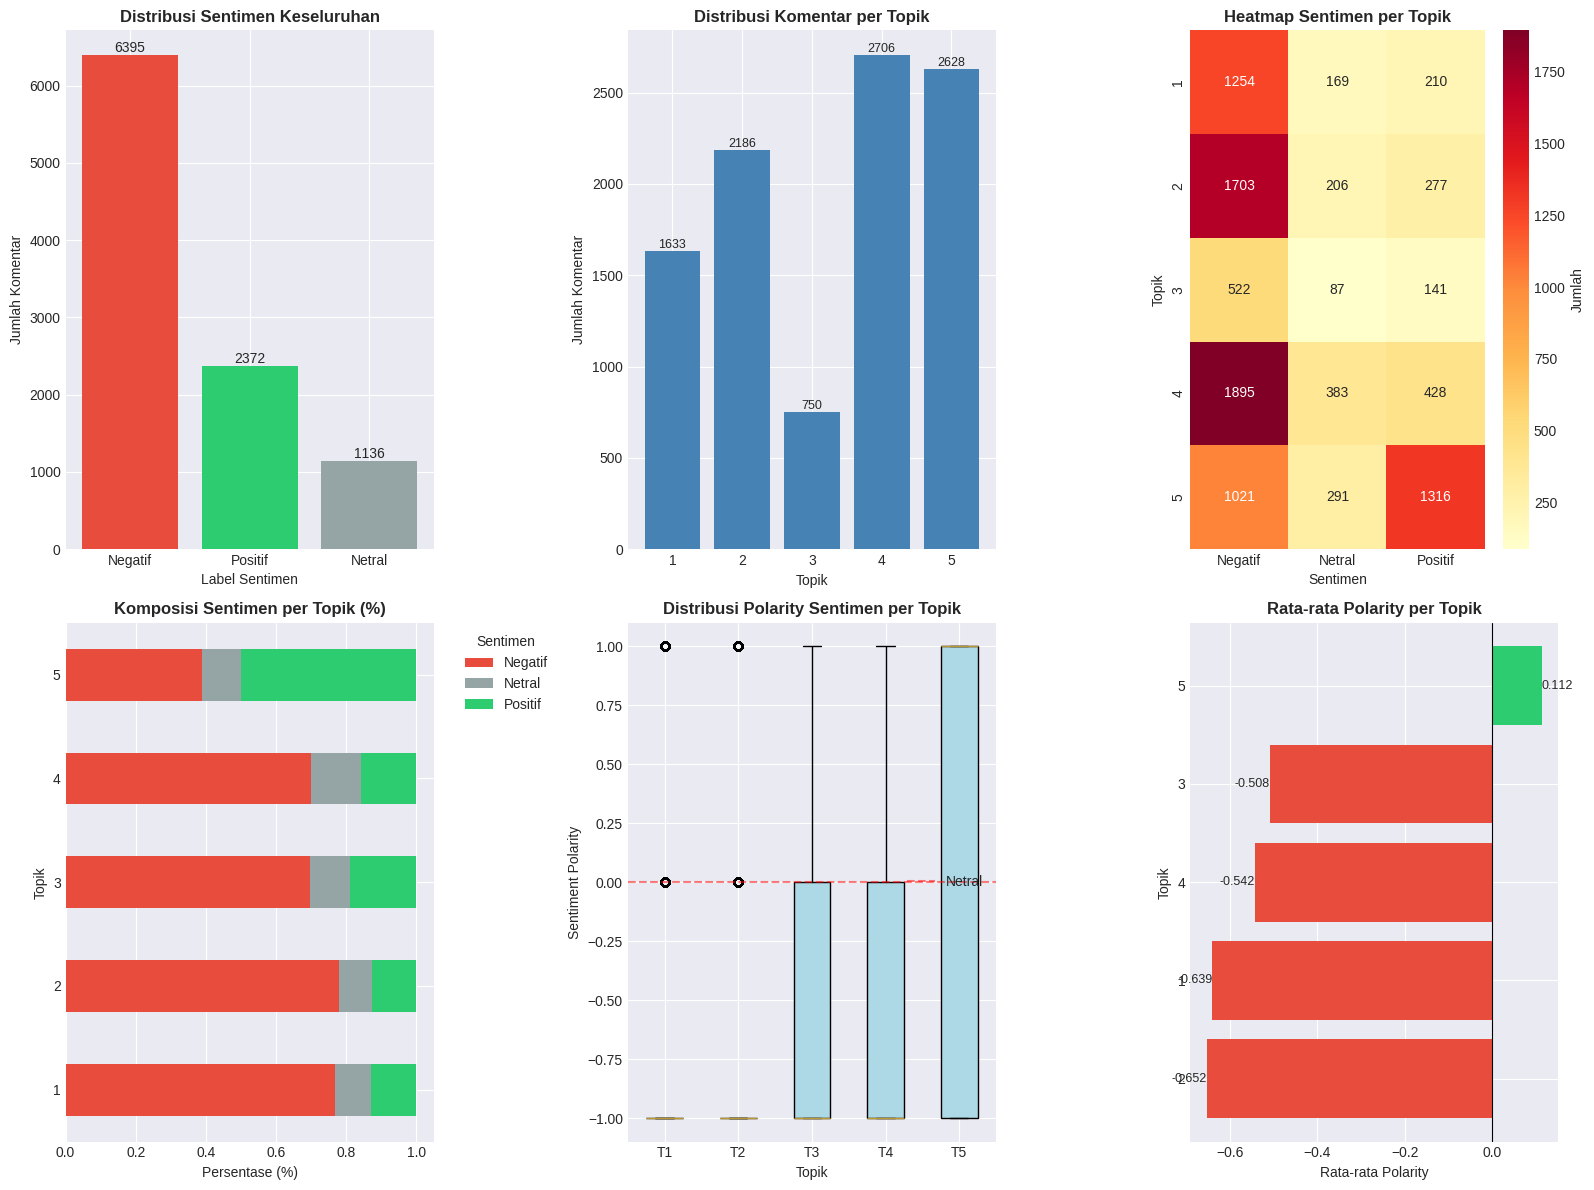

In [8]:
# Membuat figure dengan multiple subplots
fig = plt.figure(figsize=(16, 12))

# Hitung agregasi yang dibutuhkan untuk visualisasi
# Sentimen per Topik
aspect_sentiment = df.groupby(['dominant_topic', 'sentiment_label']).size().unstack(fill_value=0)
# Normalisasi untuk persentase
aspect_sentiment_pct = aspect_sentiment.apply(lambda x: x / x.sum(), axis=1)
# Rata-rata polarity per Topik
avg_polarity_topic = df.groupby('dominant_topic')['sentiment_polarity'].mean()

# 1. Distribusi Sentimen Keseluruhan
ax1 = plt.subplot(2, 3, 1)
sentiment_counts = df['sentiment_label'].value_counts()
colors = {'Positif': '#2ecc71', 'Netral': '#95a5a6', 'Negatif': '#e74c3c'}
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors[x] for x in sentiment_counts.index])
ax1.set_title('Distribusi Sentimen Keseluruhan', fontsize=12, fontweight='bold')
ax1.set_xlabel('Label Sentimen')
ax1.set_ylabel('Jumlah Komentar')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

# 2. Distribusi Topik
ax2 = plt.subplot(2, 3, 2)
topic_counts = df['dominant_topic'].value_counts().sort_index()
ax2.bar(topic_counts.index.astype(str), topic_counts.values, color='steelblue')
ax2.set_title('Distribusi Komentar per Topik', fontsize=12, fontweight='bold')
ax2.set_xlabel('Topik')
ax2.set_ylabel('Jumlah Komentar')
for i, v in enumerate(topic_counts.values):
    ax2.text(i, v, f'{v}', ha='center', va='bottom', fontsize=9)

# 3. Heatmap Sentimen per Topik
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(aspect_sentiment, annot=True, fmt='d', cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Jumlah'})
ax3.set_title('Heatmap Sentimen per Topik', fontsize=12, fontweight='bold')
ax3.set_xlabel('Sentimen')
ax3.set_ylabel('Topik')

# 4. Stacked Bar Chart Sentimen per Topik (Persentase)
ax4 = plt.subplot(2, 3, 4)
aspect_sentiment_pct.plot(kind='barh', stacked=True, ax=ax4,
                          color=[colors.get(x, 'gray') for x in aspect_sentiment_pct.columns])
ax4.set_title('Komposisi Sentimen per Topik (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Persentase (%)')
ax4.set_ylabel('Topik')
ax4.legend(title='Sentimen', bbox_to_anchor=(1.05, 1), loc='upper left')

# 5. Box Plot Polarity per Topik
ax5 = plt.subplot(2, 3, 5)
topic_list = sorted(df['dominant_topic'].unique())
data_for_box = [df[df['dominant_topic'] == topic]['sentiment_polarity'].values for topic in topic_list]
bp = ax5.boxplot(data_for_box, labels=[f'T{t}' for t in topic_list], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax5.set_title('Distribusi Polarity Sentimen per Topik', fontsize=12, fontweight='bold')
ax5.set_xlabel('Topik')
ax5.set_ylabel('Sentiment Polarity')
ax5.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Netral')
ax5.legend()

# 6. Bar Chart Rata-rata Polarity per Topik
ax6 = plt.subplot(2, 3, 6)
avg_polarity_sorted = avg_polarity_topic.sort_values()
colors_bar = ['#e74c3c' if x < 0 else '#2ecc71' if x > 0 else '#95a5a6' for x in avg_polarity_sorted.values]
bars = ax6.barh(avg_polarity_sorted.index.astype(str), avg_polarity_sorted.values, color=colors_bar)
ax6.set_title('Rata-rata Polarity per Topik', fontsize=12, fontweight='bold')
ax6.set_xlabel('Rata-rata Polarity')
ax6.set_ylabel('Topik')
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
for i, v in enumerate(avg_polarity_sorted.values):
    ax6.text(v, i, f'{v:.3f}', ha='left' if v >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualisasi_sentimen_aspek.png', dpi=300, bbox_inches='tight')
print("Visualisasi berhasil disimpan: visualisasi_sentimen_aspek.png")
print()

In [9]:
print("\n1. RINGKASAN SENTIMEN KESELURUHAN:")
for label, count in sentiment_counts.items():
    print(f"   - {label}: {count} komentar ({count/len(df)*100:.2f}%")

print("\n2. TOPIK DENGAN SENTIMEN PALING POSITIF:")
top_positive = avg_polarity_topic.head(3)
for i, (topic, polarity) in enumerate(top_positive.items(), 1):
    print(f"   {i}. Topik {topic}: {polarity:.4f}")

print("\n3. TOPIK DENGAN SENTIMEN PALING NEGATIF:")
top_negative = avg_polarity_topic.tail(3)
for i, (topic, polarity) in enumerate(top_negative.items(), 1):
    print(f"   {i}. Topik {topic}: {polarity:.4f}")

print("\n4. DISTRIBUSI SENTIMEN PER TOPIK (DOMINAN):")
for topic in sorted(df['dominant_topic'].unique()):
    topic_sentiments = df[df['dominant_topic'] == topic]['sentiment_label'].value_counts()
    dominant = topic_sentiments.index[0]
    print(f"   Topik {topic}: Dominan {dominant} ({topic_sentiments.iloc[0]} dari {len(df[df['dominant_topic'] == topic])} komentar)")


1. RINGKASAN SENTIMEN KESELURUHAN:
   - Negatif: 6395 komentar (64.58%
   - Positif: 2372 komentar (23.95%
   - Netral: 1136 komentar (11.47%

2. TOPIK DENGAN SENTIMEN PALING POSITIF:
   1. Topik 1: -0.6393
   2. Topik 2: -0.6523
   3. Topik 3: -0.5080

3. TOPIK DENGAN SENTIMEN PALING NEGATIF:
   1. Topik 3: -0.5080
   2. Topik 4: -0.5421
   3. Topik 5: 0.1123

4. DISTRIBUSI SENTIMEN PER TOPIK (DOMINAN):
   Topik 1: Dominan Negatif (1254 dari 1633 komentar)
   Topik 2: Dominan Negatif (1703 dari 2186 komentar)
   Topik 3: Dominan Negatif (522 dari 750 komentar)
   Topik 4: Dominan Negatif (1895 dari 2706 komentar)
   Topik 5: Dominan Positif (1316 dari 2628 komentar)


In [10]:
# Export hasil sentimen ke CSV
output_df = df[['textDisplay', 'text_clean', 'text_processed', 'dominant_topic',
                'sentiment_polarity', 'sentiment_label', 'likeCount']]
output_df.to_csv('/content/hasil_analisis_sentimen.csv', index=False, encoding='utf-8-sig')
print("File hasil analisis disimpan: hasil_analisis_sentimen.csv")

# Export ringkasan per topik
summary_data = []
for topic in sorted(df['dominant_topic'].unique()):
    topic_df = df[df['dominant_topic'] == topic]
    for sentiment in ['Positif', 'Netral', 'Negatif']:
        count = len(topic_df[topic_df['sentiment_label'] == sentiment])
        pct = count / len(topic_df) * 100
        summary_data.append({
            'Topik': topic,
            'Sentimen': sentiment,
            'Jumlah': count,
            'Persentase': f"{pct:.2f}%"
        })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('/content/ringkasan_sentimen_per_topik.csv', index=False, encoding='utf-8-sig')
print("File ringkasan per topik disimpan: ringkasan_sentimen_per_topik.csv")

File hasil analisis disimpan: hasil_analisis_sentimen.csv
File ringkasan per topik disimpan: ringkasan_sentimen_per_topik.csv
